In [1]:
# bibliotecas
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np

import tensorflow_hub as hub
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score

ModuleNotFoundError: No module named 'matplotlib'

### Carregamento e Pré-Processamento do Dataset

In [2]:
from utils.data_utils_keras import load_and_preprocess_data_tf, ModelType

batch_size = 64
image_size = (224, 224)
train_ds, test_ds = load_and_preprocess_data_tf(resize_to=image_size,
                                                batch_size=batch_size,
                                                model_type=ModelType.MOBILENET_V2)

Found 100000 files belonging to 2 classes.


I0000 00:00:1748928888.759174  948292 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3647 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
I0000 00:00:1748928888.760152  948292 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 3588 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


Found 20000 files belonging to 2 classes.


### Divisão Holdout

In [3]:
total_batches = tf.data.experimental.cardinality(train_ds).numpy()
total_samples = total_batches * batch_size

In [4]:
# Define proporção de treino (70%) e validação (30%) usando o número de batches
train_batches = int(total_batches * 0.7)
val_batches = total_batches - train_batches

In [5]:
# Embaralha os batches do dataset
train_ds_shuffled = train_ds.shuffle(buffer_size=1000, seed=42, reshuffle_each_iteration=False)

In [6]:
# Divisão trenio e validação
train_ds = train_ds_shuffled.take(train_batches)
val_ds = train_ds_shuffled.skip(train_batches)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [7]:
print(f"Batches de treino: {train_batches}")
print(f"Batches de validação: {val_batches}")
print(f"Aproximadamente {train_batches * batch_size} amostras de treino")
print(f"Aproximadamente {val_batches * batch_size} amostras de validação")

Batches de treino: 1094
Batches de validação: 469
Aproximadamente 70016 amostras de treino
Aproximadamente 30016 amostras de validação


## Treino

### Modelo

**ResNet50**

O ResNet50 é uma arquitetura de rede neural convolucional profunda de ponta, desenvolvida pela Microsoft Research em 2015. É uma variante da popular arquitetura ResNet e compreende 50 camadas que permitem o aprendizado de arquiteturas muito mais profundas do que era possível anteriormente, sem o problema de gradientes que desaparecem. 

A arquitetura do ResNet50 é dividida em quatro partes principais: as camadas convolucionais, o bloco de identidade, o bloco convolucional e as camadas totalmente conectadas. As camadas convolucionais são responsáveis ​​por extrair características da imagem de entrada, o bloco de identidade e o bloco convolucional processam e transformam essas características, e as camadas totalmente conectadas fazem a classificação final. O ResNet50 foi treinado no grande conjunto de dados ImageNet, alcançando uma taxa de erro equivalente ao desempenho humano, tornando-o um modelo poderoso para diversas tarefas de classificação de imagens, como detecção de objetos, reconhecimento facial e análise de imagens médicas. Além disso, também tem sido usado como um extrator de características para outras tarefas, como detecção de objetos e segmentação semântica.

Fonte: https://medium.com/@nitishkundu1993/exploring-resnet50-an-in-depth-look-at-the-model-architecture-and-code-implementation-d8d8fa67e46f

In [8]:
device = "GPU" if len(tf.config.list_physical_devices("GPU")) > 0 else "CPU"
print(f"Usando: {device}")

Usando: GPU


In [ ]:
shufflenet_url = "https://tfhub.dev/google/imagenet/shufflenet_v2_x0.5_224/feature_vector/5"

In [9]:
base_model = hub.KerasLayer(shufflenet_url, input_shape=(*image_size, 3), trainable=False)

model = models.Sequential([
    base_model,
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=5,           
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=batch_size,
    verbose=3,
    callbacks=[early_stopping]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10


2025-06-03 05:35:19.439981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 38 of 1000
2025-06-03 05:35:29.560981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 78 of 1000
2025-06-03 05:35:49.494338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 153 of 1000
2025-06-03 05:36:09.505778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 234 of 1000
2025-06-03 05:36:19.625304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 274 of 1000
2025-06-03 05:36:39.390648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a wh

Epoch 2/10


2025-06-03 05:59:35.265349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 26 of 1000
2025-06-03 05:59:45.425183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 56 of 1000
2025-06-03 05:59:55.961327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 85 of 1000
2025-06-03 06:00:15.199388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 143 of 1000
2025-06-03 06:00:25.348463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 172 of 1000
2025-06-03 06:00:35.390101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a whi

Epoch 3/10


2025-06-03 06:22:09.905783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 20 of 1000
2025-06-03 06:22:20.099395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 50 of 1000
2025-06-03 06:22:39.920241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 111 of 1000
2025-06-03 06:22:49.982086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 141 of 1000
2025-06-03 06:23:09.803247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 200 of 1000
2025-06-03 06:23:29.853169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a wh

Epoch 4/10


2025-06-03 06:45:15.263554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 24 of 1000
2025-06-03 06:45:25.262923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 51 of 1000
2025-06-03 06:45:45.411487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 110 of 1000
2025-06-03 06:46:05.204585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 171 of 1000
2025-06-03 06:46:25.448482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 233 of 1000
2025-06-03 06:46:45.354368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a wh

Epoch 5/10


2025-06-03 07:07:30.170434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 22 of 1000
2025-06-03 07:07:50.192060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 77 of 1000
2025-06-03 07:08:00.227524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 107 of 1000
2025-06-03 07:08:20.652549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 167 of 1000
2025-06-03 07:08:39.955382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 225 of 1000
2025-06-03 07:08:50.246083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a wh

Epoch 6/10


2025-06-03 07:29:04.175884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 22 of 1000
2025-06-03 07:29:23.964796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 80 of 1000
2025-06-03 07:29:34.095630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 109 of 1000
2025-06-03 07:29:44.317281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 135 of 1000
2025-06-03 07:30:04.249172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 195 of 1000
2025-06-03 07:30:14.330281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a wh

Epoch 7/10


2025-06-03 07:52:34.795126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 25 of 1000
2025-06-03 07:52:54.530626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 103 of 1000
2025-06-03 07:53:14.424704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 184 of 1000
2025-06-03 07:53:24.524593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 225 of 1000
2025-06-03 07:53:44.462692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 305 of 1000
2025-06-03 07:54:04.474553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

Epoch 8/10


2025-06-03 08:16:45.761121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 25 of 1000
2025-06-03 08:17:05.176646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 79 of 1000
2025-06-03 08:17:15.284895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 112 of 1000
2025-06-03 08:17:25.478429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 142 of 1000
2025-06-03 08:17:44.975853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 203 of 1000
2025-06-03 08:17:55.365429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a wh

Epoch 9/10


2025-06-03 08:40:10.353221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 27 of 1000
2025-06-03 08:40:30.320331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 88 of 1000
2025-06-03 08:40:49.809318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 150 of 1000
2025-06-03 08:41:00.120103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 181 of 1000
2025-06-03 08:41:20.192998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 247 of 1000
2025-06-03 08:41:40.715050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a wh

Epoch 10/10


2025-06-03 09:02:46.574539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 21 of 1000
2025-06-03 09:03:06.809980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 83 of 1000
2025-06-03 09:03:26.647537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 144 of 1000
2025-06-03 09:03:36.667564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 175 of 1000
2025-06-03 09:03:56.882396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 236 of 1000
2025-06-03 09:04:16.677845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a wh

313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 160ms/step


2025-06-03 09:27:05.602842: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


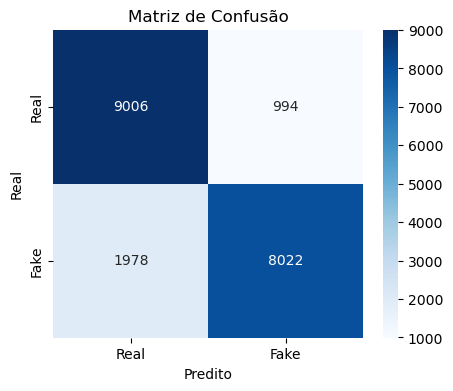


Relatório de Classificação:
              precision    recall  f1-score   support

        Real       0.82      0.90      0.86     10000
        Fake       0.89      0.80      0.84     10000

    accuracy                           0.85     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.85      0.85      0.85     20000

AUC (ROC): 0.9351


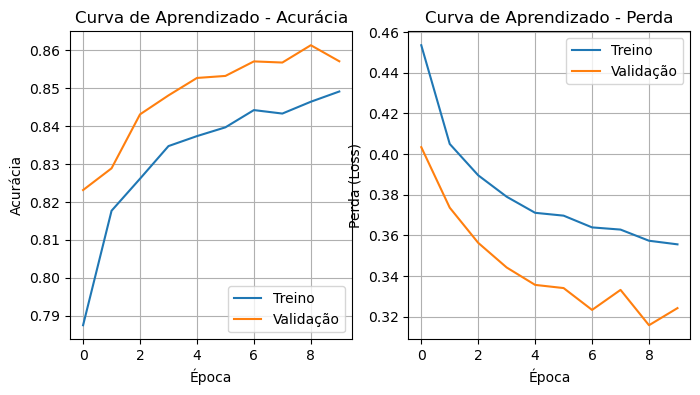

In [10]:
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

# Extrair labels verdadeiros do dataset de teste
y_test = []
for _, labels in test_ds:
    y_test.extend(labels.numpy())
y_test = np.array(y_test)

# Flatten y_pred_prob para garantir formato correto
y_pred_prob = y_pred_prob.ravel()

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC (ROC): {roc_auc:.4f}")

plt.figure(figsize=(8, 4))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title("Curva de Aprendizado - Acurácia")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()
plt.grid()

# Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title("Curva de Aprendizado - Perda")
plt.xlabel("Época")
plt.ylabel("Perda (Loss)")
plt.legend()
plt.grid()

plt.show()